# Aggregated Decadal trends 
Generate Decadal plot of D2+ SD frequency and uncertainty across ensemble members

In [6]:
import sys
sys.path.append("../notebooks")
from imports import *

mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")
num_snowy = np.array(mask_ds.snow >20).flatten().sum()

In [9]:
def to_decadal(rootdir, ens_num: str, threshold : float=-1.3):
    # get files
    hist_file = os.path.join(rootdir, f"hist/hist_monthly_ens_{ens_num}.nc")
    future_file = os.path.join(rootdir, f"future245/future_monthly_ens_{ens_num}.nc")
    
    # open datsets and concat
    hist_zscores = xr.open_dataset(hist_file)
    future_zscores = xr.open_dataset(future_file)
    zscores = xr.concat([hist_zscores, future_zscores], dim='time').sortby('time')

    
    # reindex to West CONUS (remove Canada) and convert time to pandas
    zscores = zscores.reindex(lat = zscores.lat[zscores.lat <=49])
    zscores = zscores.sel(time=is_winter(zscores['time.month']))
    #zscores['time'] = zscores.indexes['time'].to_datetimeindex()
    
    # resample to 10 year frequency
    zscores = (zscores < threshold).resample(time="10Y", closed='left').sum()
    
        
    # open mask for snowy region and add time dimension corresponding to zscores
    mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")
    mask = mask_ds.expand_dims(dim={'time': zscores.time})
    
    # mask to snowy regions
    zscores = zscores.where(mask.snow > 20)
    
    return zscores

In [10]:
%%time
def is_winter(month):
    return (month <=4) | (month >=10)
rootdir = "/work/Julian.Schmitt/data/zscores/snowi/"
all_ens_members = [to_decadal(rootdir, str(i).zfill(2)) for i in range(1, 31)]

CPU times: user 3.12 s, sys: 808 ms, total: 3.92 s
Wall time: 7.53 s


In [11]:
# drop the spatial dimension - here we look at the overall Western US trend
agg_ens_drought = [np.array(ens.groupby('time').sum(['lat', 'lon']).zscores)/num_snowy
                                                                   for ens in all_ens_members]
ens_mean = sum([ens.zscores for ens in all_ens_members])/30

In [12]:
# low emission scenario
rootdir45 = "/work/Julian.Schmitt/data/zscores/snowi/"
all_ens_members45 = [to_decadal(rootdir45, str(i).zfill(2)) for i in range(1, 31)]

# get ensemble mean for 4.5
ens_mean45 = sum([ens.zscores for ens in all_ens_members45])/30

# aggregate/sum by decade for total drought months
agg_ens_drought45 = [np.array(ens.groupby('time').sum(['lat', 'lon']).zscores)/num_snowy
                                                                 for ens in all_ens_members45]
# get ensemble mean averages 
agg_ens_mean45 = ens_mean45.groupby('time').sum(['lat', 'lon'])/num_snowy
agg_ens_mean = ens_mean.groupby('time').sum(['lat', 'lon'])/num_snowy

In [13]:
# confidence intervals for ensemble mean
dates = np.arange(1920, 2100, 10)
CI45s = []
for ind, decade in enumerate(dates):
    data = [agg_ens_drought45[i][ind] for i in range(len(agg_ens_drought45))]
    CI = st.t.interval(alpha=0.95, df = len(data)-1, loc=np.mean(data), scale=st.sem(data))
    CI45s.append(CI)
CI45_low = [elt[0] for elt in CI45s]
CI45_high = [elt[1] for elt in CI45s]

CI85s = []
for ind, decade in enumerate(dates):
    data = [agg_ens_drought[i][ind] for i in range(len(agg_ens_drought))]
    CI = st.t.interval(alpha=0.95, df = len(data)-1, loc=np.mean(data), scale=st.sem(data))
    CI85s.append(CI)
CI85_low = [elt[0] for elt in CI85s]
CI85_high = [elt[1] for elt in CI85s]

In [14]:
# Calculations for percent increases
# calculate the percent increase of snow droughts by scenario
p_ens_mean45 = agg_ens_mean45/70*100
p_ens_mean85 = agg_ens_mean/70*100
p_increase45 = float(p_ens_mean45[-1]/np.mean(p_ens_mean45[:9]))
p_increase85 = float(p_ens_mean85[-1]/np.mean(p_ens_mean85[:9]))

print(p_increase45, p_increase85)

float(p_ens_mean85[-5]/np.mean(p_ens_mean85[:9]))

5.286535638912291 5.286535638912291


4.200700507576426

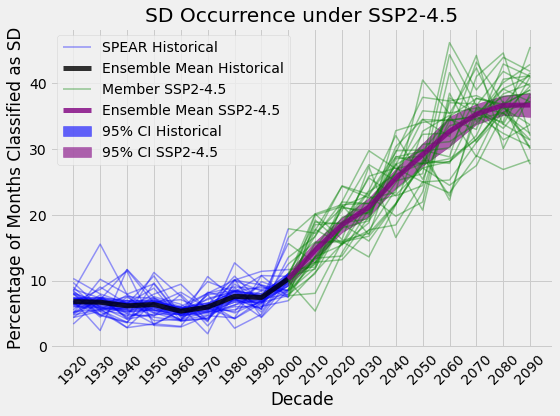

In [19]:
plt.style.use("fivethirtyeight")
dates = np.arange(1920, 2100, 10)
fig = plt.figure(figsize=(8,6))
############ HISTORICAL ##########
# add ensemble members
for ind, ens_member in enumerate(agg_ens_drought45):
    if ind ==1: # only add one legend label, convert to percentage
        plt.plot(dates[:9], (ens_member[:9] /70*100), color='blue', linewidth=1.5, alpha=0.4, label="SPEAR Historical")
    else:
        plt.plot(dates[:9], (ens_member[:9] /70*100), color='blue', linewidth=1.5, alpha=0.4)

# add ensemble mean
plt.plot(dates[:9], (agg_ens_mean45[:9] /70 *100), color='k', linewidth=5, alpha=0.8, label="Ensemble Mean Historical")

# add CI
plt.fill_between(dates[:9], (np.array(CI45_low[:9])/70*100), (np.array(CI45_high[:9])/70*100), color='blue', alpha=0.6, label="95% CI Historical")
###################################

############# RCP 4.5 ############
# add ensemble members
for ind, ens_member in enumerate(agg_ens_drought45):
    if ind ==1: # only add one legend label, convert to percentage
        plt.plot(dates[8:], (ens_member[8:] /70*100), color='green', linewidth=1.5, alpha=0.4, label="Member SSP2-4.5")
    else:
        plt.plot(dates[8:], (ens_member[8:] /70*100), color='green', linewidth=1.5, alpha=0.4)

# add ensemble mean
plt.plot(dates[8:], (agg_ens_mean45[8:] /70 *100), color='purple', linewidth=5, alpha=0.8, label="Ensemble Mean SSP2-4.5")

# add CI
plt.fill_between(dates[8:], (np.array(CI45_low[8:])/70*100), (np.array(CI45_high[8:])/70*100), color='purple', alpha=0.6, label="95% CI SSP2-4.5")
###################################

# ############ RCP 8.5 ##############
# # add ensemble members
# for ind, ens_member in enumerate(agg_ens_drought):
#     if ind ==1: # only add one legend label
#         plt.plot(dates[8:], (ens_member[8:] /70*100), color='orange', linewidth=1.5, alpha=0.4, label="Member SSP5-8.5")
#     else:
#         plt.plot(dates[8:], (ens_member[8:] /70*100), color='orange', linewidth=1.5, alpha=0.4)

# # add ensemble mean
# plt.plot(dates[8:], (agg_ens_mean[8:] /70*100), color='red', linewidth=4, alpha=0.8, label="Ensemble Mean SSP5-8.5")

# plt.fill_between(dates[8:], (np.array(CI85_low[8:]) /70*100), (np.array(CI85_high[8:]) /70*100), color='red', alpha=0.6, label = "95% CI SSP5-8.5")




# add labels
plt.title("SD Occurrence under SSP2-4.5")
plt.xlabel("Decade")
plt.ylabel("Percentage of Months Classified as SD")
plt.legend()
plt.xticks(dates, rotation=45);
plt.tight_layout()